## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [ ]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:00<00:00, 94.4MB/s]


In [ ]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=a30adbbd-2c1e-4c07-b511-03cde83ff2d3
To: /content/coco_captions.npy
100% 415M/415M [00:02<00:00, 139MB/s]


In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.j

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [ ]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())
coco_dset1 = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json')

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=2.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [ ]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [ ]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [ ]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [ ]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [ ]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre)
        accuracy += score
    return accuracy/len(predict)

In [ ]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

Results for IndexFlatL2:


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

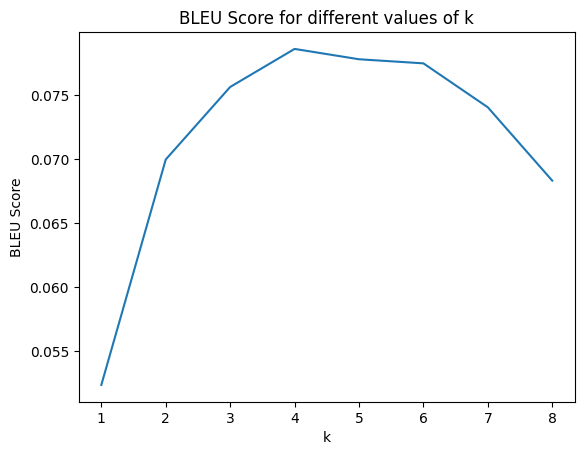

Best k: 4, Best BLEU Score: 0.07858927497397541

Results for IndexIVFFlat:


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

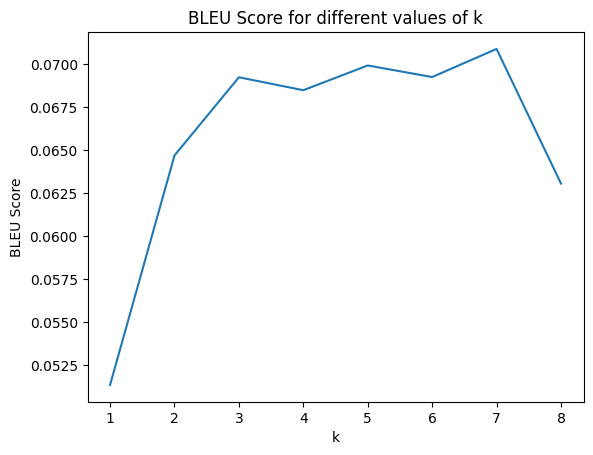

Best k: 7, Best BLEU Score: 0.07089093705136926

Results for IndexHNSWFlat:


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

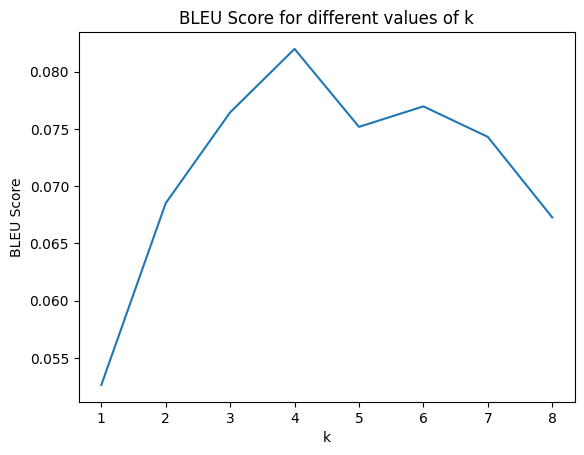

Best k: 4, Best BLEU Score: 0.08198089539351838
5 IMAGES FOR INDEX FLAT L2 
################################################################
['A woman skiing down the side of a snow covered ski slope.'
 'A young lady travels down the ski slopes dressed in a bright red and white ski suit.'
 'Someone skiing down a course on a hill.'
 'A person skiing down a hill passing by a blue marker.'
 'A downhill skier is attempting to navigate an obstacle course.']


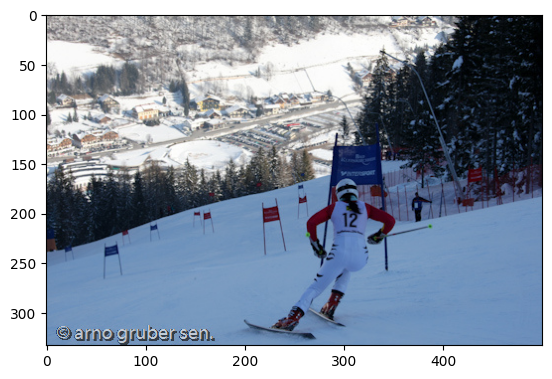

A woman skis down a snowy ski slope.
#################################################################
################################################################
['A man is standing near a canopy bed.'
 'a man in his bedroom getting ready and a bed well made'
 'A man standing next to a bed while holding his hands together.'
 'A man standing near a bed with a red and green canopy.'
 'a four poster bed covered with red and green curtains behind a man']


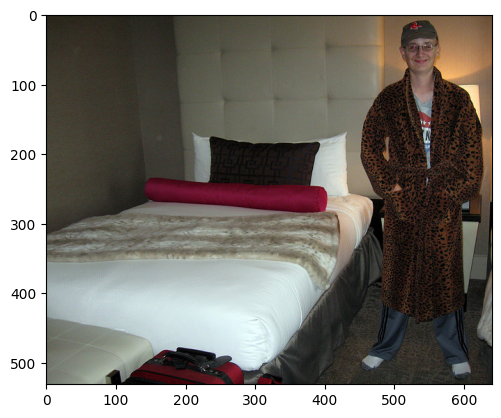

A man in a leopard robe stands next to a bed
#################################################################
################################################################
['a small metallic toilet in a tile bathroom'
 'A picture of a toilet and toilet paper in a bathroom.'
 'A metal toilet bowl against a tiled wall'
 'A brown toilet inside of a public restroom.'
 'A silver toilet that has no movable seat on it.']


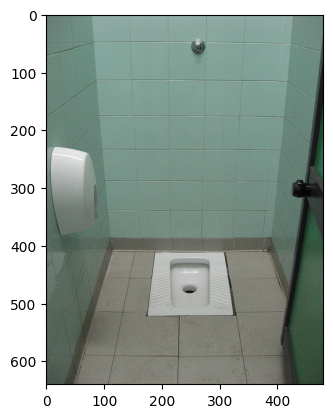

A toilet sits in the middle of the floor of the stall
#################################################################
################################################################
['A crowd of people walking across a cross walk.'
 'A crowded crosswalk in a city with many store fronts. '
 'THERE ARE A LOT OF PEPOLE THAT ARE WALKING IN THE STREET'
 'There is a large quantity of people crossing the street in the cross walk.'
 'Many pedestrians are walking across the city street.']


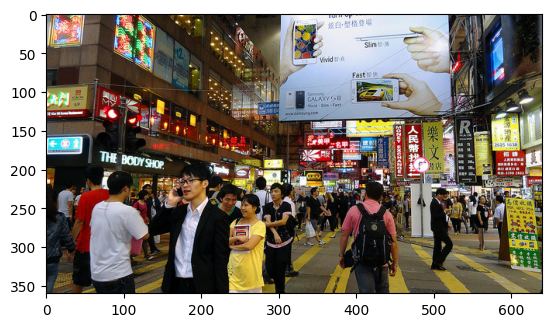

A general public walking and shopping at a local shopping district.
#################################################################
################################################################
['A group of cows relaxing in the grass in front of a barn.'
 'This is an image of a barn with several cows in front of it.'
 'The cattle are lying in the green pasture.'
 'A herd of cows laying in  a field by a barn.'
 'horses laying down on the grass beside trees and a barn']


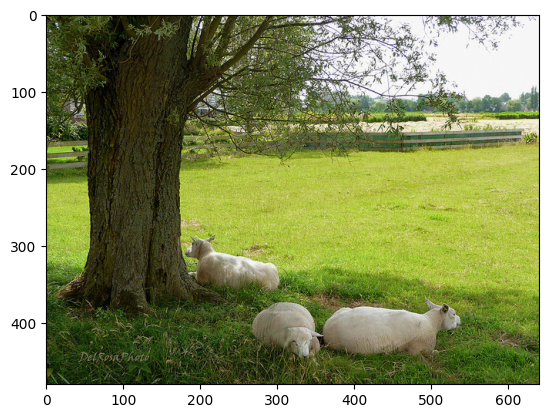

A group of sheep lying in the shade under a tree.
#################################################################
5 IMAGES FOR INDEX IVF FLAT 
################################################################
['A woman skiing down the side of a snow covered ski slope.'
 'A young lady travels down the ski slopes dressed in a bright red and white ski suit.'
 'Someone skiing down a course on a hill.'
 'A person skiing down a hill passing by a blue marker.'
 'A downhill skier is attempting to navigate an obstacle course.']


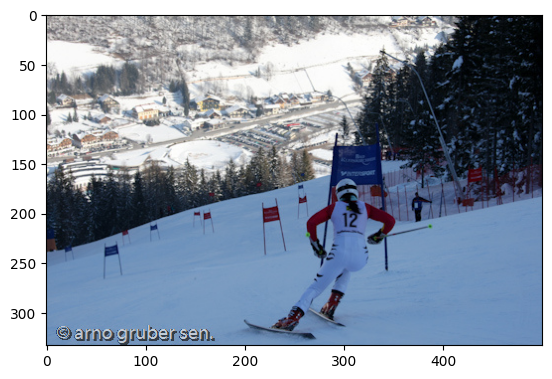

A woman skis down a snowy ski slope.
#################################################################
################################################################
['A man is standing near a canopy bed.'
 'a man in his bedroom getting ready and a bed well made'
 'A man standing next to a bed while holding his hands together.'
 'A man standing near a bed with a red and green canopy.'
 'a four poster bed covered with red and green curtains behind a man']


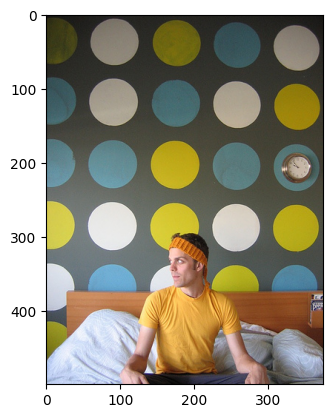

A man sits on a bed against a polka-dotted wall.
#################################################################
################################################################
['a small metallic toilet in a tile bathroom'
 'A picture of a toilet and toilet paper in a bathroom.'
 'A metal toilet bowl against a tiled wall'
 'A brown toilet inside of a public restroom.'
 'A silver toilet that has no movable seat on it.']


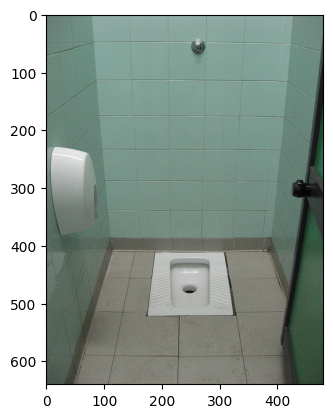

A toilet sits in the middle of the floor of the stall
#################################################################
################################################################
['A crowd of people walking across a cross walk.'
 'A crowded crosswalk in a city with many store fronts. '
 'THERE ARE A LOT OF PEPOLE THAT ARE WALKING IN THE STREET'
 'There is a large quantity of people crossing the street in the cross walk.'
 'Many pedestrians are walking across the city street.']


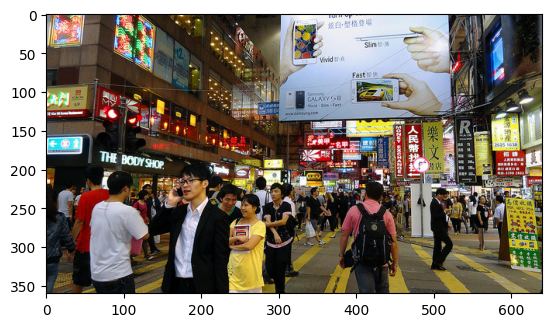

A general public walking and shopping at a local shopping district.
#################################################################
################################################################
['A group of cows relaxing in the grass in front of a barn.'
 'This is an image of a barn with several cows in front of it.'
 'The cattle are lying in the green pasture.'
 'A herd of cows laying in  a field by a barn.'
 'horses laying down on the grass beside trees and a barn']


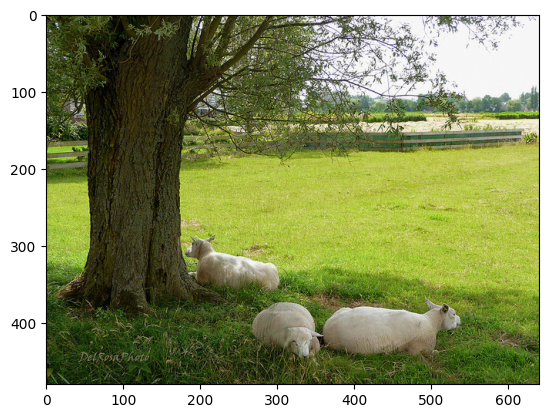

A group of sheep lying in the shade under a tree.
#################################################################
5 IMAGES FOR INDEX HNSW 
################################################################
['A woman skiing down the side of a snow covered ski slope.'
 'A young lady travels down the ski slopes dressed in a bright red and white ski suit.'
 'Someone skiing down a course on a hill.'
 'A person skiing down a hill passing by a blue marker.'
 'A downhill skier is attempting to navigate an obstacle course.']


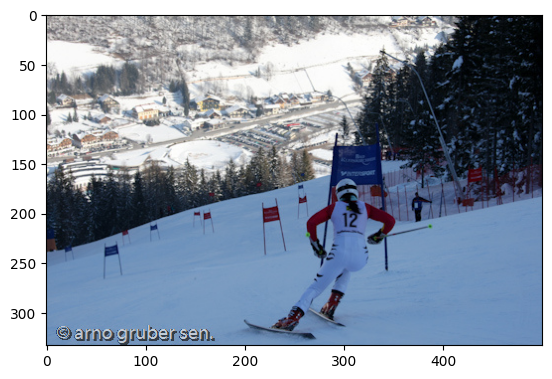

A woman skis down a snowy ski slope.
#################################################################
################################################################
['A man is standing near a canopy bed.'
 'a man in his bedroom getting ready and a bed well made'
 'A man standing next to a bed while holding his hands together.'
 'A man standing near a bed with a red and green canopy.'
 'a four poster bed covered with red and green curtains behind a man']


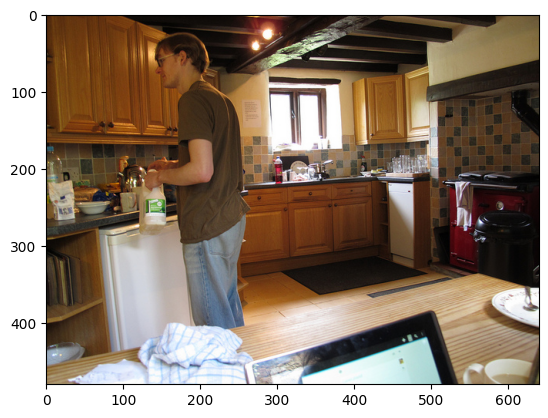

A man in the kitchen holding a container of milk.
#################################################################
################################################################
['a small metallic toilet in a tile bathroom'
 'A picture of a toilet and toilet paper in a bathroom.'
 'A metal toilet bowl against a tiled wall'
 'A brown toilet inside of a public restroom.'
 'A silver toilet that has no movable seat on it.']


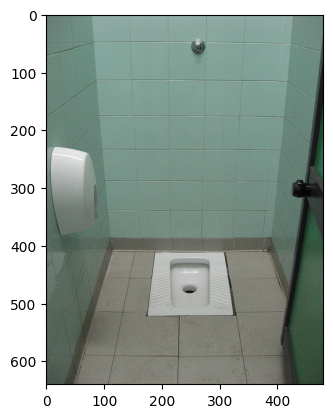

A toilet sits in the middle of the floor of the stall
#################################################################
################################################################
['A crowd of people walking across a cross walk.'
 'A crowded crosswalk in a city with many store fronts. '
 'THERE ARE A LOT OF PEPOLE THAT ARE WALKING IN THE STREET'
 'There is a large quantity of people crossing the street in the cross walk.'
 'Many pedestrians are walking across the city street.']


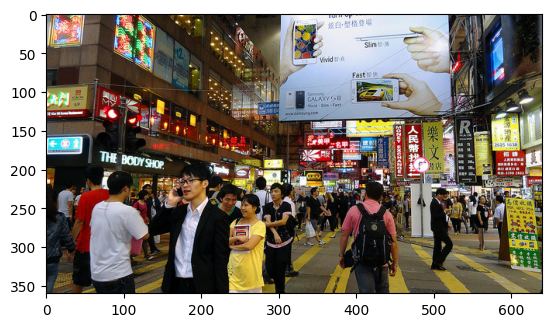

A general public walking and shopping at a local shopping district.
#################################################################
################################################################
['A group of cows relaxing in the grass in front of a barn.'
 'This is an image of a barn with several cows in front of it.'
 'The cattle are lying in the green pasture.'
 'A herd of cows laying in  a field by a barn.'
 'horses laying down on the grass beside trees and a barn']


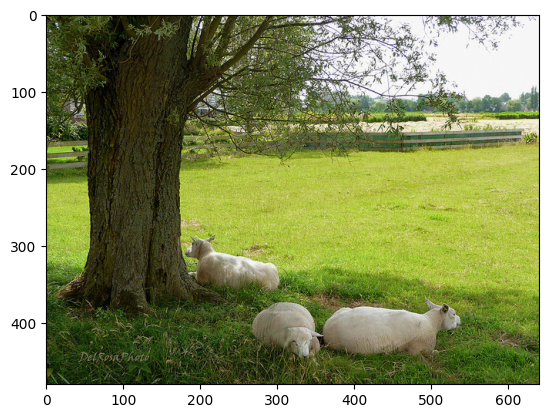

A group of sheep lying in the shade under a tree.
#################################################################


In [ ]:
import faiss
import numpy as np
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

class KNN_captioning:

    def __init__(self, image_embeddings, caption_embeddings, captions_np, index_type="IndexFlatL2", index_params=None):
        self.image_embeddings = image_embeddings
        self.caption_embeddings = caption_embeddings
        self.captions_np = captions_np
        self.index_type = index_type
        self.index_params = index_params
        self.index = self.build_index()

    def build_index(self):
      dimension = self.image_embeddings.shape[1]

      if self.index_type == "IndexFlatL2":
          index = faiss.IndexFlatL2(dimension)
          image_embeddings_flat = np.array(image_embeddings[:40000], dtype='float32').reshape(-1, dimension)
          index.train(np.array(self.image_embeddings[:40000], dtype='float32').reshape(-1, dimension))
          index.add(image_embeddings_flat)
          return index
      elif self.index_type == "IndexIVFFlat":
          nlist = self.index_params.get("nlist", 100)
          quantizer = faiss.IndexFlatL2(dimension)
          index = faiss.IndexIVFFlat(quantizer, dimension, nlist)
          index.train(np.array(self.image_embeddings[:40000], dtype='float32').reshape(-1, dimension))
          index.add(np.array(self.image_embeddings[:40000], dtype='float32').reshape(-1, dimension))
          return index
      elif self.index_type == "IndexHNSWFlat":
          nlinks = self.index_params.get("nlinks", 32)
          index = faiss.IndexHNSWFlat(dimension, nlinks)
          index.train(np.array(self.image_embeddings[:40000], dtype='float32').reshape(-1, dimension))
          index.add(np.array(self.image_embeddings[:40000], dtype='float32').reshape(-1, dimension))
          return index
      else:
          raise ValueError(f"Unsupported index type: {self.index_type}")



    def best_image_caption_index(self, query_index, query_vector, search_results):
        best_image_index = float('-inf')
        best_caption_index = float('-inf')
        max_similarity = float('-inf')

        for result_index in search_results:
            captions = self.caption_embeddings[result_index]

            for caption_index, caption_embedding in enumerate(captions):
                similarity = cosine_similarity(query_vector.reshape(1, -1), caption_embedding.reshape(1, -1))[0, 0]

                if similarity > max_similarity:
                    max_similarity = similarity
                    best_image_index = result_index
                    best_caption_index = caption_index

        return self.captions_np[best_image_index][best_caption_index]



    def plot_and_display_results(self, results, best_k):
        plt.plot(list(results.keys()), list(results.values()))
        plt.xlabel('k')
        plt.ylabel('BLEU Score')
        plt.title('BLEU Score for different values of k')
        plt.show()

        print(f"Best k: {best_k}, Best BLEU Score: {results[best_k]}")
        return results[best_k]



    def evaluate_and_plot(self, k_values):
        results = {}
        for k in k_values:
            actual = []
            predicted = []
            for i in range(40001, 40503):
                D, I = self.index.search(np.array(self.image_embeddings[i].reshape(1, -1), dtype='float32'), k)
                similarities = 1 / (1 + D[0])
                nearest_caption_embeddings = self.caption_embeddings[I[0], :, :]
                weighted_sum = np.sum(nearest_caption_embeddings * similarities[:, np.newaxis, np.newaxis], axis=(0, 1))
                q = weighted_sum / (k * 5)
                closest_captions = self.best_image_caption_index(i, q, I[0])
                actual.append(self.captions_np[i])
                predicted.append(closest_captions)
            bleu_score = accuracy_v2(predicted, actual)
            results[k] = bleu_score
        best_k = max(results, key=results.get)
        return self.plot_and_display_results(results,best_k)



    def best_image_caption_index2(self, query_index, query_vector, search_results):
      best_image_index = float('-inf')
      best_caption_index = float('-inf')
      max_similarity = float('-inf')

      for result_index in search_results:
          captions = self.caption_embeddings[result_index]

          for caption_index, caption_embedding in enumerate(captions):
              similarity = cosine_similarity(query_vector.reshape(1, -1), caption_embedding.reshape(1, -1))[0, 0]

              if similarity > max_similarity:
                  max_similarity = similarity
                  best_image_index = result_index
                  best_caption_index = caption_index
      print("################################################################")
      img1, target1 = coco_dset1[query_index]
      print(self.captions_np[query_index])
      plt.show()
      img2, target2 = coco_dset1[best_image_index]
      plt.imshow(img2)
      plt.show()
      print(self.captions_np[best_image_index][best_caption_index])
      print("#################################################################")




    def eval_and_plot_5(self,best_k):
        results = {}
        best_k = max(int(best_k),1)
       # for k in k_values:
        actual = []
        predicted = []
        for i in range(40050, 40055):
            D, I = self.index.search(np.array(self.image_embeddings[i].reshape(1, -1), dtype='float32'),best_k )
            similarities = 1 / (1 + D[0])
            nearest_caption_embeddings = self.caption_embeddings[I[0], :, :]
            weighted_sum = np.sum(nearest_caption_embeddings * similarities[:, np.newaxis, np.newaxis], axis=(0, 1))
            q = weighted_sum / (best_k * 5)
            closest_captions2 = self.best_image_caption_index2(i, q, I[0])
            actual.append(self.captions_np[i])
            predicted.append(closest_captions2)




################################DRIVER CODE####################################################################################3


caption_reranker_flatl2 = KNN_captioning(image_embeddings, caption_embeddings, captions_np, index_type="IndexFlatL2", index_params={100})
caption_reranker_ivf = KNN_captioning(image_embeddings,caption_embeddings,captions_np,index_type="IndexIVFFlat",index_params={"nlist": 100})
caption_reranker_hnsw = KNN_captioning(image_embeddings,caption_embeddings,captions_np,index_type="IndexHNSWFlat",index_params={"nlinks": 32})
k_values = [k for k in range(1,9)]
print("Results for IndexFlatL2:")
best_k_flatL2 = caption_reranker_flatl2.evaluate_and_plot(k_values)
print("\nResults for IndexIVFFlat:")
best_k_IVF = caption_reranker_ivf.evaluate_and_plot(k_values)
print("\nResults for IndexHNSWFlat:")
best_k_HNSW = caption_reranker_hnsw.evaluate_and_plot(k_values)

##########################VISUALISING 5 IMAGES##################################################
print("5 IMAGES FOR INDEX FLAT L2 ")
caption_reranker_flatl2.eval_and_plot_5(best_k_flatL2)
print("5 IMAGES FOR INDEX IVF FLAT ")
caption_reranker_ivf.eval_and_plot_5(best_k_IVF)
print("5 IMAGES FOR INDEX HNSW ")
caption_reranker_hnsw.eval_and_plot_5(best_k_HNSW)
##########################################################################################################################
